# ANALYSIS FRO ECML-PKDD 2025

If you need to change kernel:
- ctrl + shift + p
- select interpreter Python --> /leonardo_work/try25_pellegrino/Water_Resources/env/bin/python3.10
- then select new kernel in the upper-right corner of the notebook

In [2]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from keras import activations
from tqdm import tqdm

from skimage.transform import resize
from sklearn.metrics import mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

import os
import copy


2025-03-09 11:56:52.767814: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 11:56:54.305187: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 11:56:58.235729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-09 11:56:58.240412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-09 11:56:58.672374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [46]:
# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = "/leonardo_work/try25_pellegrino/"  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_images_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_image_sequences_dates.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_images_dates = np.load(v_test_images_dates_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_images_dates))
print(len(vottignasco_test_OHE))

105
105
105
105


In [4]:
sample_result_path = "Water_Resources/rise-video/XAI/spatial_temporal/results/01_marco_st_lime_shap_20250308184201/lime_shap_st_results_setup_ns_7_comp_10.pkl"

# Spatial

# Temporal

## Functions

In [107]:
#From test_exec_lime_shap_temp.ipynb

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

# Funzione per determinare la stagione in base al giorno dell'anno
def get_season(day):
    spring = np.arange(80, 172)
    summer = np.arange(172, 264)
    fall = np.arange(264, 355)

    if day in spring:
        return 'Spring'
    elif day in summer:
        return 'Summer'
    elif day in fall:
        return 'Autumn'
    else:
        return 'Winter'

season_colors = {
    'Winter': '#AEC6CF',  # Azzurro chiaro
    'Spring': '#77DD77',  # Verde menta
    'Summer': '#FFD700',  # Giallo dorato
    'Autumn': '#FF8C00'   # Arancione scuro
}

def plot_saliency_vector(saliency_vector, test_dates, test_images_dates, instance_number, input_size=104):
    dates = pd.to_datetime(test_images_dates[instance_number])
    tm_days = [date.timetuple().tm_yday for date in dates]
    seasons = [get_season(tm_yday) for tm_yday in tm_days]
    colors = [season_colors[season] for season in seasons]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(np.arange(input_size), saliency_vector, color='black')

    # Evidenzia le stagioni come intervalli
    season_intervals = []
    start = 0
    current_season = seasons[0]

    for j in range(1, input_size):
        if seasons[j] != current_season:
            season_intervals.append((start, j, current_season))
            start = j
            current_season = seasons[j]
    season_intervals.append((start, input_size, current_season))

    max_saliency = max(saliency_vector)
    min_saliency = min(saliency_vector)
    #print(max_saliency, min_saliency)
    text_offset = max_saliency * +0.06  # Aggiunge un po' di spazio sopra il valore massimo

    for start, end, season in season_intervals:
        ax.axvspan(start, end, color=season_colors[season], alpha=0.2)
        ax.text((start + end) / 2, max_saliency + text_offset, season, color=season_colors[season], fontsize=10, ha='center', va='bottom')

    # Seleziona le date a intervalli regolari per i tick dell'asse x
    month_indices = np.linspace(0, input_size - 1, num=12, dtype=int)
    month_labels = [f"{dates[i].strftime('%b')} {dates[i].year}" for i in month_indices]

    ax.set_xticks(month_indices)
    ax.set_xticklabels(month_labels, rotation=45)

    # Linee tratteggiate per separare i time-step
    for i in range(input_size):
        ax.axvline(x=i, color='grey', linestyle='-', alpha=0.1)

    # Impostare i limiti dell'asse y tra il minimo e massimo della saliency
    ax.set_ylim(min_saliency, max_saliency + (max_saliency - min_saliency) * 0.05)  # Padding solo sopra il max

    
    # Impostare i tick dell'asse y automaticamente in base ai valori della saliency
    ax.yaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))  # Genera tick ragionevoli

    ax.set_title(f"Temporal Saliency Vector for Instance #{instance_number}, Target Date: {test_dates[instance_number][0].astype(str).split('T')[0]}\n(Impact of each week on groundwater level prediction)", pad=26)
    #ax.set_xlabel('Time-step')
    ax.set_ylabel('Saliency score (Relevance of each time-step)')

    fig.subplots_adjust(left=0.1, right=0.9)
    fig.tight_layout()
    plt.show()

## Analysis

In [98]:
sample_result_path = "Water_Resources/rise-video/XAI/temporal/results/01_marco_temporal_lime_shap_20250308151700/lime_shap_all_temporal_results.pkl"

In [99]:
# Loading results
result_st = None
path_to_load_results = os.path.join(work_path, sample_result_path)

with open(path_to_load_results, 'rb') as file:
  result_st = pickle.load(file)

print(result_st)

{'lime': {'kw_50_alpha_0.1': {'coefficients': [array([-7.59504905e-03,  2.02570992e-02,  9.07849308e-03,  4.88994047e-02,
        5.28761247e-02,  4.87344091e-02, -3.26951803e-04,  1.16937715e+00,
        5.62984545e-03]), array([0.00672642, 0.02040336, 0.00848003, 0.04512695, 0.05744674,
       0.05063668, 0.00720934, 1.11852537, 0.00961554]), array([-7.30370632e-04,  1.62140467e-02,  6.04968362e-03,  5.21117656e-02,
        5.27451115e-02,  5.61983103e-02,  1.09077619e-02,  1.06667223e+00,
        2.99695864e-02]), array([-0.00856509,  0.02234142,  0.00313783,  0.04758995,  0.04782626,
        0.05059359,  0.00361552,  1.01087994,  0.01826474]), array([0.00676514, 0.01232103, 0.00142843, 0.04374672, 0.05063174,
       0.04644362, 0.00543066, 0.97538743, 0.02000172]), array([0.00539587, 0.01142384, 0.00279354, 0.04112111, 0.05016331,
       0.05144501, 0.00401654, 0.92022384, 0.01970848]), array([0.00177028, 0.01134636, 0.00438681, 0.02935988, 0.0485519 ,
       0.05040025, 0.00132929

In [100]:
result_st = result_st["lime"]

In [101]:
result_st.keys()

dict_keys(['kw_50_alpha_0.1', 'kw_90_alpha_0.1', 'kw_50_alpha_10.0', 'kw_90_alpha_10.0'])

In [102]:
result_st = result_st["kw_90_alpha_0.1"]

In [103]:
result_st.keys()

dict_keys(['coefficients', 'saliency_vectors', 'errors_insertion', 'auc_insertion', 'errors_deletion', 'auc_deletion', 'executions_times', 'parameters_comb'])

In [104]:
result_st["saliency_vectors"].shape

(105, 104)

In [105]:
print("Statistics: \n")
print(f"Mean: {result_st['saliency_vectors'].mean()}")
print(f"Std: {result_st['saliency_vectors'].std()}")
print(f"Min: {result_st['saliency_vectors'].min()}")
print(f"Max: {result_st['saliency_vectors'].max()}")

Statistics: 

Mean: 0.1062817073544869
Std: 0.26275413572450873
Min: -0.08782270202242055
Max: 1.9768604202580606


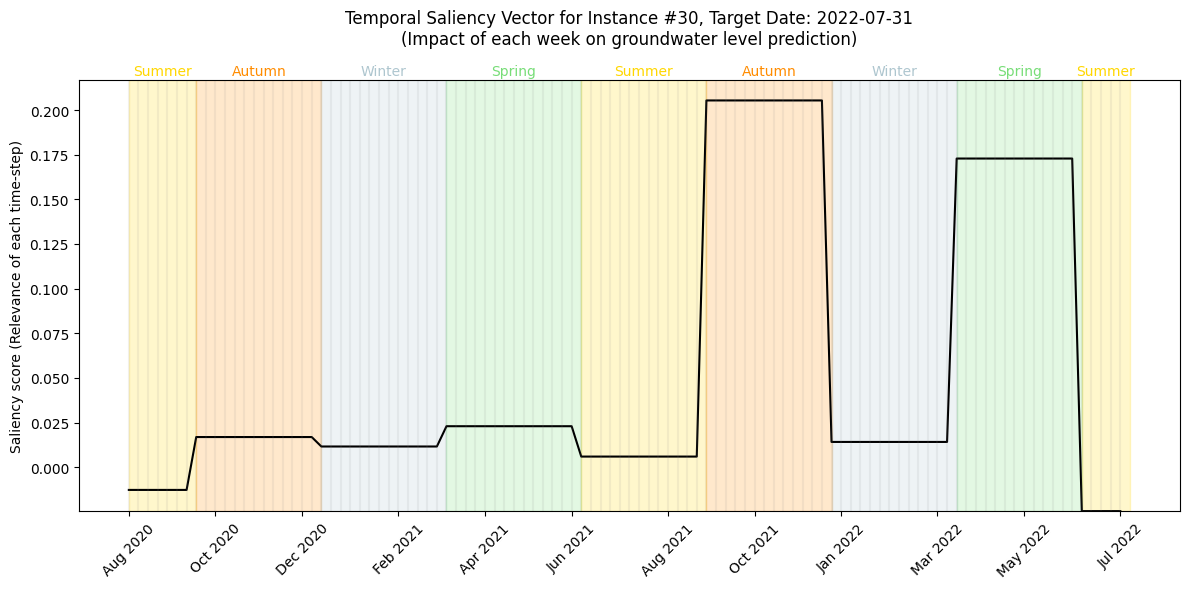

In [109]:
nr_instance = 30
plot_saliency_vector(result_st["saliency_vectors"][nr_instance], vottignasco_test_dates,
                     vottignasco_test_images_dates, nr_instance)

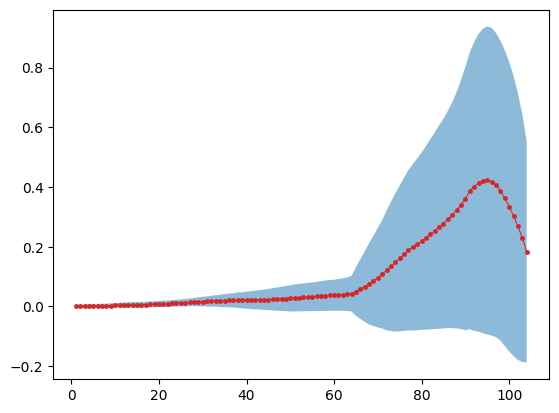

In [110]:
# TO DO WITH SAME INSTANCES BUT DIFFERENT SEEDS

ensamble_saliency = result_st["saliency_vectors"].mean(axis = 0)
ensamble_saliency_std = result_st["saliency_vectors"].std(axis = 0)

fig, ax = plt.subplots()

tstep = np.arange(1, 105, 1)
ax.fill_between(tstep,
                ensamble_saliency - ensamble_saliency_std,
                ensamble_saliency + ensamble_saliency_std,
                alpha = 0.5, lw = 1.5, ls = "--")

ax.plot(tstep, ensamble_saliency, marker = "o", lw = 0.75, markersize = 2.5, color = "tab:red")

plt.show()

In [111]:
def plot_saliency_vector_ens(saliency_vector, saliency_vector_std,
                         test_dates, test_images_dates, instance_number, input_size=104):
    
    dates = pd.to_datetime(test_images_dates[instance_number])
    tm_days = [date.timetuple().tm_yday for date in dates]
    seasons = [get_season(tm_yday) for tm_yday in tm_days]
    colors = [season_colors[season] for season in seasons]

    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.fill_between(np.arange(input_size),
                saliency_vector - saliency_vector_std,
                saliency_vector + saliency_vector_std)
    
    ax.plot(np.arange(input_size), saliency_vector, color='black')

    # Evidenzia le stagioni come intervalli
    season_intervals = []
    start = 0
    current_season = seasons[0]

    for j in range(1, input_size):
        if seasons[j] != current_season:
            season_intervals.append((start, j, current_season))
            start = j
            current_season = seasons[j]
    season_intervals.append((start, input_size, current_season))

    max_saliency = max(saliency_vector) + max(saliency_vector_std)
    min_saliency = min(saliency_vector) - min(saliency_vector_std)
    #print(max_saliency, min_saliency)
    text_offset = max_saliency * +0.06  # Aggiunge un po' di spazio sopra il valore massimo

    for start, end, season in season_intervals:
        ax.axvspan(start, end, color=season_colors[season], alpha=0.2)
        ax.text((start + end) / 2, max_saliency + text_offset, season, color=season_colors[season], fontsize=10, ha='center', va='bottom')

    # Seleziona le date a intervalli regolari per i tick dell'asse x
    month_indices = np.linspace(0, input_size - 1, num=12, dtype=int)
    month_labels = [f"{dates[i].strftime('%b')} {dates[i].year}" for i in month_indices]

    ax.set_xticks(month_indices)
    ax.set_xticklabels(month_labels, rotation=45)

    # Linee tratteggiate per separare i time-step
    for i in range(input_size):
        ax.axvline(x=i, color='grey', linestyle='-', alpha=0.1)

    # Impostare i limiti dell'asse y tra il minimo e massimo della saliency
    ax.set_ylim(min_saliency, max_saliency + (max_saliency - min_saliency) * 0.05)  # Padding solo sopra il max

    
    # Impostare i tick dell'asse y automaticamente in base ai valori della saliency
    ax.yaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))  # Genera tick ragionevoli

    ax.set_title(f"Temporal Saliency Vector for Instance #{instance_number}, Target Date: {test_dates[instance_number][0].astype(str).split('T')[0]}\n(Impact of each week on groundwater level prediction)", pad=26)
    #ax.set_xlabel('Time-step')
    ax.set_ylabel('Saliency score (Relevance of each time-step)')

    fig.subplots_adjust(left=0.1, right=0.9)
    fig.tight_layout()
    plt.show()

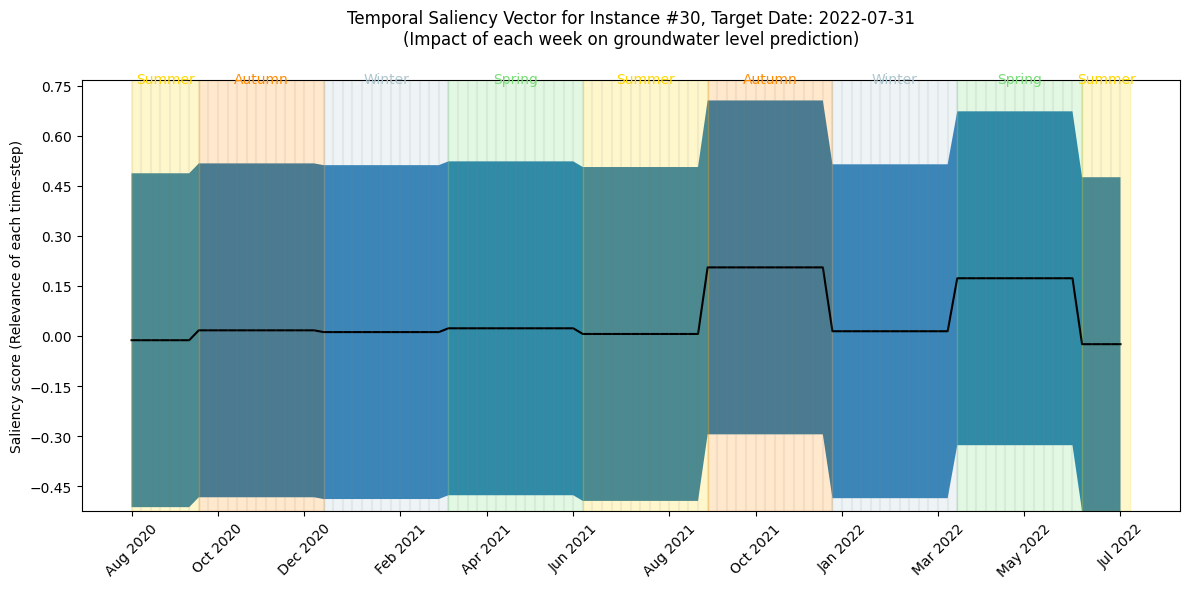

In [113]:
nr_instance = 30
plot_saliency_vector_ens(result_st["saliency_vectors"][nr_instance],
                     np.zeros_like(result_st["saliency_vectors"][nr_instance]) + 0.5,
                     vottignasco_test_dates,
                     vottignasco_test_images_dates, nr_instance)

# Spatio-Temporal

In [114]:
sample_result_path = "Water_Resources/rise-video/XAI/spatial_temporal/results/01_marco_st_lime_shap_20250308184201/lime_shap_st_results_setup_ns_7_comp_10.pkl"

In [115]:
# Loading results
result_st = None
path_to_load_results = os.path.join(work_path, sample_result_path)

with open(path_to_load_results, 'rb') as file:
  result_st = pickle.load(file)

print(result_st)

{'lime': {'ns_7_comp_10_kw_50_alpha_0.1': {'coefficients': [array([ 3.41945408e-03, -1.85111532e-03, -6.86530282e-03, -6.49710375e-04,
        6.14184904e-05, -2.39694158e-03,  6.85143012e-03,  1.22701912e-02,
        4.41033518e-03, -1.88664723e-03,  1.34855686e-02, -1.27989620e-04,
        1.10588114e-02,  2.77952044e-03, -4.31232136e-03,  2.26931486e-03,
        3.37921935e-03,  1.39094982e-02,  4.90911092e-04, -7.34375459e-03,
        3.37503840e-03,  2.71943274e-02,  4.48322385e-03,  5.87536537e-03,
        1.82891196e-02,  1.10856761e-02,  9.67663337e-03,  6.11016425e-03,
        2.76017624e-02,  1.18225920e-02,  2.79423337e-02,  8.28200288e-03,
        6.03969270e-03,  1.52669183e-02,  1.72595493e-02,  3.06587221e-02,
        6.77104151e-04, -1.93718112e-03,  2.92508816e-02, -4.05860114e-03,
        2.48763130e-02,  1.72334739e-02, -7.22868046e-03,  3.52966636e-03,
       -3.44600607e-04,  5.00514966e-03,  1.95368097e-04,  6.68552479e-03,
        6.44317172e-03,  4.93132707e-01,

In [116]:
saliency_video = result_st["lime"]["ns_7_comp_10_kw_90_alpha_0.1"]["saliency_videos"] #coefficients for LIME
#saliency_video = result_st["coefficients"][nr_instance] # saliency_video for RISE

# saliency_video = result_st["saliency_videos"].mean(axis=0)

In [87]:
saliency_video.shape

(105, 104, 5, 8)

In [ ]:
print("Statistics: \n")
print(f"Mean: {saliency_video.mean()}")
print(f"Std: {saliency_video.std()}")
print(f"Min: {saliency_video.min()}")
print(f"Max: {saliency_video.max()}")

Statistics: 

Mean: 0.03032624215096489
Std: 0.09207439924355215
Min: -0.1067470283903896
Max: 0.7855638937195368


In [117]:
nr_instance = 30
saliency_video = saliency_video[nr_instance]

In [134]:
video_np = copy.deepcopy(saliency_video)

video_perc = np.percentile(video_np, 95)
print(video_perc)
print(video_perc.shape)

0.10871288920677795
()


In [135]:
video_np[video_np < video_perc] = np.nan

1) per ogni frame trovare zona (contorno) più significativa
2) plottare l'area per ogni time step, colorando solo il bordo

In [136]:
# Create a meshgrid for the 3D coordinates
x, y, z = np.indices(video_np.shape)

# Flatten the arrays for plotting
x_flat = x.ravel()
y_flat = y.ravel()
z_flat = z.ravel()
data_flat = video_np.ravel()

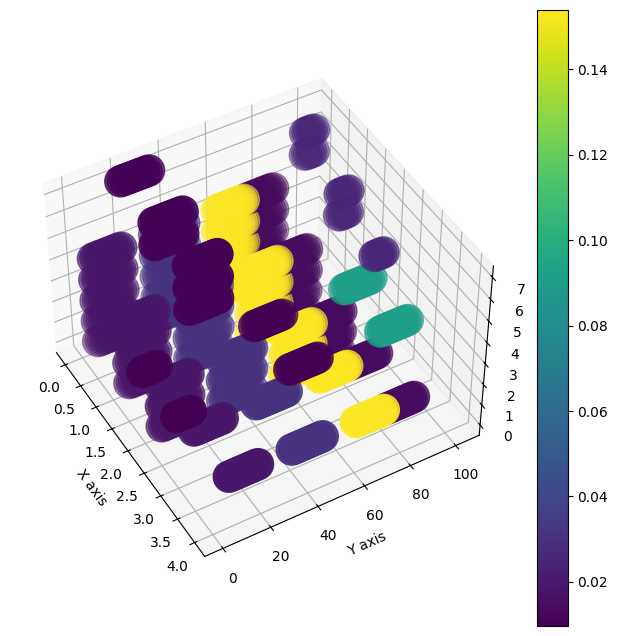

In [133]:
# Create a figure and axis for 3D plotting
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot, with color based on the value of the point
sc = ax.scatter(y_flat, x_flat, z_flat, s=500, c=data_flat, marker="o", cmap='viridis')

# Add a color bar
plt.colorbar(sc)

# Labels for axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

el = 45
az = -30
ax.view_init(el, az) 

# ax.plot_surface(x[0], y[0], z[0], rstride=1, cstride=1)

# Show plot
plt.show()

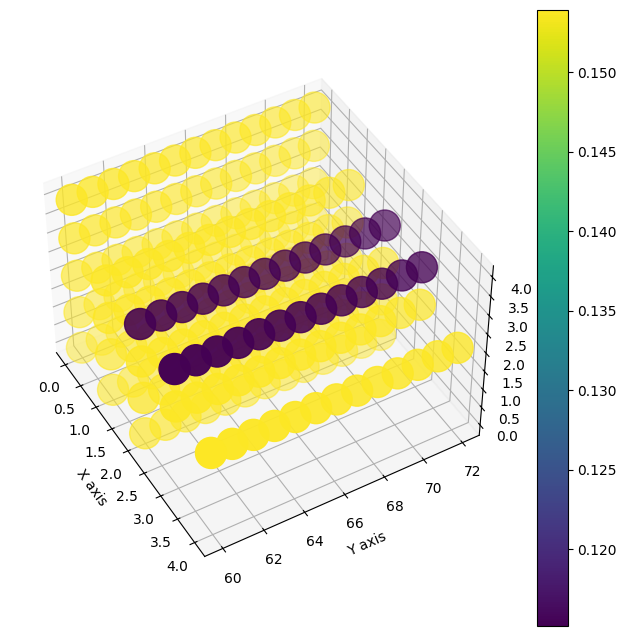

In [137]:
# Create a figure and axis for 3D plotting
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot, with color based on the value of the point
sc = ax.scatter(y_flat, x_flat, z_flat, s=500, c=data_flat, marker="o", cmap='viridis')

# Add a color bar
plt.colorbar(sc)

# Labels for axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

el = 45
az = -30
ax.view_init(el, az) 

# ax.plot_surface(x[0], y[0], z[0], rstride=1, cstride=1)

# Show plot
plt.show()

In [139]:
saliency_video[0].shape

(5, 8)

In [152]:
_, prova_t = cv2.threshold(img, threshold_value, max_val, cv2.THRESH_BINARY	) 

In [153]:
contours, _ = cv2.findContours(prova_t, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/contours_new.cpp:327: error: (-2:Unspecified error) in function 'static std::shared_ptr<ContourScanner_> ContourScanner_::create(cv::Mat, int, int, cv::Point)'
> Modes other than RETR_FLOODFILL and RETR_CCOMP support only CV_8UC1 images (expected: 'img.type() == CV_8UC1'), where
>     'img.type()' is 6 (CV_64FC1)
> must be equal to
>     'CV_8UC1' is 0 (CV_8UC1)


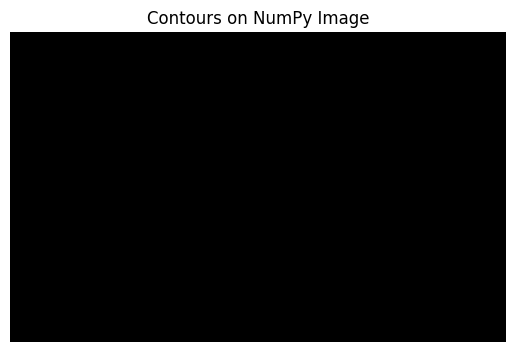

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che 'img_array' sia la tua immagine in formato NumPy
# img_array.shape -> (H, W), immagine in scala di grigi

# Soglia per selezionare i pixel alti
img = saliency_video[0]
threshold_value = np.percentile(img, 90)
max_val = img.max()

# img_norm = cv2.normalize(img, None, alpha=img.min(), beta=img.max(), norm_type=cv2.NORM_MINMAX)

# # Converte in uint8 senza perdere informazioni relative alla forma
# img_norm = img_norm.astype(np.uint8)

_, binary = cv2.threshold(img, threshold_value, max_val, cv2.THRESH_BINARY)

# Trova i contorni
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Disegna i contorni sull'immagine originale
contour_img = cv2.cvtColor(img_norm, cv2.COLOR_GRAY2BGR)  # Converti in RGB per disegnare i contorni
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)  # Verde

# Mostra il risultato
plt.imshow(contour_img)
plt.title("Contours on NumPy Image")
plt.axis("off")
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Esempio di immagine NumPy con valori float64 tra 0 e 1
img_array = np.random.rand(100, 100)  

# Normalizza l'immagine tra 0 e 255
img_norm = cv2.normalize(img_array, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Converte in uint8 senza perdere informazioni relative alla forma
img_uint8 = img_norm.astype(np.uint8)

# Usa Otsu per una soglia automatica
_, binary = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Trova i contorni
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Disegna i contorni
contour_img = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)  # Converti in RGB per visualizzazione
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)  # Verde

# Mostra il risultato
plt.imshow(contour_img)
plt.title("Contours on Normalized Image")
plt.axis("off")
plt.show()
